## Étape 1 : Génération de données synthétiques réalistes pour le churn

In [17]:
# importation des bibliothèques nécessaires
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

# Fixer le seed pour la reproductibilité
np.random.seed(42)
n = 1_000_000

# Distributions des variables
contrats = ['Prépayé', 'Postpayé', 'Forfait Illimité']
internet_services = ['ADSL', 'Fibre', '4G', 'Aucun']
langues = ['Français', 'Arabe', 'Amazigh']
regions = ['Nord', 'Sud', 'Est', 'Ouest', 'Centre']
paiements = ['Carte bancaire', 'Espèces', 'Virement', 'PayPal']
appareils = ['Android', 'iPhone', 'Autre']
operateurs = ['Maroc Telecom', 'Orange', 'Inwi']

# Génération du DataFrame
data = pd.DataFrame({
    'contrat': np.random.choice(contrats, n, p=[0.4, 0.4, 0.2]),
    'internet_service': np.random.choice(internet_services, n, p=[0.3, 0.3, 0.3, 0.1]),
    'langue_preferee': np.random.choice(langues, n, p=[0.6, 0.3, 0.1]),
    'region': np.random.choice(regions, n),
    'methode_paiement': np.random.choice(paiements, n),
    'type_appareil': np.random.choice(appareils, n, p=[0.7, 0.25, 0.05]),
    'operateur': np.random.choice(operateurs, n, p=[0.5, 0.3, 0.2]),
    'age': np.random.randint(18, 80, n),
    'revenu': np.random.normal(6000, 1500, n).clip(1000, 20000),
    'anciennete': np.random.exponential(scale=3, size=n).clip(0, 20).round(1)
})

# ============================================================
# IMPROVED: Realistic Churn Probability Modeling
# ============================================================
# Initialize churn probability array
churn_prob = np.zeros(n)

# Factor 1: Contract type influence (Prépayé clients churn more)
churn_prob += (data['contrat'] == 'Prépayé').values * 0.25
churn_prob += (data['contrat'] == 'Postpayé').values * 0.08
churn_prob += (data['contrat'] == 'Forfait Illimité').values * 0.05

# Factor 2: Service quality and availability
churn_prob += (data['internet_service'] == 'Aucun').values * 0.30
churn_prob += (data['internet_service'] == 'ADSL').values * 0.15  # Slower service
churn_prob += (data['internet_service'] == '4G').values * 0.08
churn_prob += (data['internet_service'] == 'Fibre').values * 0.03  # Best service

# Factor 3: Customer loyalty (tenure/ancienneté)
churn_prob += (data['anciennete'] < 0.5).values * 0.40  # Very new customers
churn_prob += ((data['anciennete'] >= 0.5) & (data['anciennete'] < 2)).values * 0.20
churn_prob += ((data['anciennete'] >= 2) & (data['anciennete'] < 5)).values * 0.10
# Long-term customers (5+ years) get no additional churn risk

# Factor 4: Age demographics (younger and older customers churn more)
churn_prob += (data['age'] < 25).values * 0.12  # Young, less stable
churn_prob += (data['age'] > 65).values * 0.10  # Elderly, may downgrade

# Factor 5: Income level (low income = higher price sensitivity)
churn_prob += (data['revenu'] < 3000).values * 0.18
churn_prob += ((data['revenu'] >= 3000) & (data['revenu'] < 5000)).values * 0.10
churn_prob += (data['revenu'] > 15000).values * 0.05  # High income, less sensitive

# Factor 6: Payment friction (Espèces indicates possible payment issues)
churn_prob += (data['methode_paiement'] == 'Espèces').values * 0.12
churn_prob += (data['methode_paiement'] == 'PayPal').values * 0.03  # Modern payment

# Factor 7: Device quality (cheaper devices may correlate with lower satisfaction)
churn_prob += (data['type_appareil'] == 'Autre').values * 0.15
churn_prob += (data['type_appareil'] == 'Android').values * 0.05
# iPhone users typically more satisfied (no penalty)

# Factor 8: Operator reputation/quality (fictional scoring)
churn_prob += (data['operateur'] == 'Inwi').values * 0.08
churn_prob += (data['operateur'] == 'Orange').values * 0.05
# Maroc Telecom is market leader (no penalty)

# Factor 9: Regional effects (some regions may have worse service)
churn_prob += (data['region'] == 'Sud').values * 0.08  # Remote areas
churn_prob += (data['region'] == 'Est').values * 0.06
# Other regions neutral

# Add realistic noise to make it non-deterministic
churn_prob += np.random.normal(0, 0.08, n)

# Clip probabilities to [0, 1] range
churn_prob = np.clip(churn_prob, 0, 1)

# Generate binary churn outcome based on probabilities
data['churn'] = (np.random.random(n) < churn_prob).astype(int)

# Aperçu rapide
print("=" * 60)
print("IMPROVED DATA GENERATION WITH REALISTIC CHURN MODELING")
print("=" * 60)
print("\nFirst rows:")
print(data.head(10))
print("\nChurn distribution:")
print(data['churn'].value_counts(normalize=True))
print(f"\nChurn rate: {data['churn'].mean():.2%}")
print("\nChurn by contract type:")
print(data.groupby('contrat')['churn'].agg(['mean', 'count']))
print("\nChurn by internet service:")
print(data.groupby('internet_service')['churn'].agg(['mean', 'count']))
print("\nChurn by tenure (binned):")
data['tenure_bin'] = pd.cut(data['anciennete'], bins=[0, 1, 3, 5, 20], labels=['<1yr', '1-3yr', '3-5yr', '5+yr'])
print(data.groupby('tenure_bin')['churn'].agg(['mean', 'count']))

# Sauvegarde
data.drop(columns=['tenure_bin']).to_csv("data/synthetic_moroccan_churn_1M.csv", index=False)
print("\n✅ Data saved to: data/synthetic_moroccan_churn_1M.csv")


IMPROVED DATA GENERATION WITH REALISTIC CHURN MODELING

First rows:
            contrat internet_service langue_preferee  region methode_paiement  \
0           Prépayé            Fibre        Français    Nord          Espèces   
1  Forfait Illimité            Fibre        Français  Centre   Carte bancaire   
2          Postpayé             ADSL           Arabe  Centre          Espèces   
3          Postpayé            Fibre        Français  Centre   Carte bancaire   
4           Prépayé               4G        Français     Est   Carte bancaire   
5           Prépayé            Fibre         Amazigh    Nord   Carte bancaire   
6           Prépayé               4G           Arabe     Est           PayPal   
7  Forfait Illimité             ADSL           Arabe    Nord   Carte bancaire   
8          Postpayé             ADSL         Amazigh     Sud           PayPal   
9          Postpayé               4G        Français   Ouest         Virement   

  type_appareil      operateur  age     

Étape 1.2 : Feature Engineering - Création de variables dérivées pour améliorer le modèle

In [18]:
# ============================================================
# FEATURE ENGINEERING: Creating Derived Features
# ============================================================

print("=" * 60)
print("FEATURE ENGINEERING")
print("=" * 60)

# 1. Interaction Features (combining multiple variables)
print("\n1. Creating interaction features...")

# Young customer with prepaid contract (high risk)
data['is_young_prepaid'] = ((data['age'] < 30) & (data['contrat'] == 'Prépayé')).astype(int)

# Low income with premium service (price sensitivity)
data['low_income_premium_service'] = (
    (data['revenu'] < 4000) & 
    (data['internet_service'].isin(['Fibre', '4G']))
).astype(int)

# New customer with no internet (exploration phase)
data['new_customer_no_internet'] = (
    (data['anciennete'] < 1) & 
    (data['internet_service'] == 'Aucun')
).astype(int)

# Cash payment with old device (possible financial constraint)
data['cash_old_device'] = (
    (data['methode_paiement'] == 'Espèces') & 
    (data['type_appareil'] == 'Autre')
).astype(int)

# 2. Ratio Features
print("2. Creating ratio features...")

# Tenure to income ratio (customer stability index)
data['tenure_income_ratio'] = data['anciennete'] / (data['revenu'] / 1000 + 1)  # +1 to avoid division issues

# Age to tenure ratio (how long relative to age)
data['age_tenure_ratio'] = data['age'] / (data['anciennete'] + 1)

# 3. Binning Continuous Variables
print("3. Binning continuous variables...")

# Age groups
data['age_group'] = pd.cut(
    data['age'], 
    bins=[0, 25, 35, 50, 65, 100], 
    labels=['18-25', '26-35', '36-50', '51-65', '65+']
)

# Revenue tiers
data['revenue_tier'] = pd.qcut(
    data['revenu'], 
    q=5, 
    labels=['very_low', 'low', 'medium', 'high', 'premium'],
    duplicates='drop'
)

# Tenure categories
data['tenure_category'] = pd.cut(
    data['anciennete'],
    bins=[-0.1, 1, 3, 5, 10, 20],
    labels=['new', 'short', 'medium', 'long', 'very_long']
)

# 4. Boolean Risk Indicators
print("4. Creating risk indicator flags...")

# High risk flags
data['is_new_customer'] = (data['anciennete'] < 1).astype(int)
data['is_low_income'] = (data['revenu'] < 3500).astype(int)
data['is_young'] = (data['age'] < 28).astype(int)
data['is_elderly'] = (data['age'] > 65).astype(int)
data['has_no_internet'] = (data['internet_service'] == 'Aucun').astype(int)
data['is_prepaid'] = (data['contrat'] == 'Prépayé').astype(int)
data['uses_cash'] = (data['methode_paiement'] == 'Espèces').astype(int)

# Loyalty score (combination of positive indicators)
data['loyalty_score'] = (
    (data['anciennete'] >= 5).astype(int) * 3 +
    (data['contrat'] == 'Forfait Illimité').astype(int) * 2 +
    (data['internet_service'] == 'Fibre').astype(int) * 2 +
    (data['type_appareil'] == 'iPhone').astype(int) * 1 +
    (data['methode_paiement'].isin(['Carte bancaire', 'PayPal'])).astype(int) * 1
)

# 5. Statistical Features
print("5. Creating statistical aggregations...")

# Revenue z-score (how far from average)
data['revenue_zscore'] = (data['revenu'] - data['revenu'].mean()) / data['revenu'].std()

# Age percentile
data['age_percentile'] = data['age'].rank(pct=True)

# Tenure percentile
data['tenure_percentile'] = data['anciennete'].rank(pct=True)

# Summary
print("\n" + "=" * 60)
print("FEATURE ENGINEERING SUMMARY")
print("=" * 60)
print(f"Original features: 11 (10 + churn)")
print(f"New features created: {len(data.columns) - 11}")
print(f"Total features now: {len(data.columns)}")
print("\nNew feature preview:")
new_features = [
    'is_young_prepaid', 'low_income_premium_service', 'tenure_income_ratio',
    'age_group', 'revenue_tier', 'loyalty_score', 'is_new_customer'
]
print(data[new_features].head(10))

print("\nLoyalty score distribution:")
print(data['loyalty_score'].value_counts().sort_index())

print("\nChurn rate by loyalty score:")
print(data.groupby('loyalty_score')['churn'].mean())


FEATURE ENGINEERING

1. Creating interaction features...
2. Creating ratio features...
3. Binning continuous variables...
4. Creating risk indicator flags...
4. Creating risk indicator flags...
5. Creating statistical aggregations...

FEATURE ENGINEERING SUMMARY
Original features: 11 (10 + churn)
New features created: 21
Total features now: 32

New feature preview:
   is_young_prepaid  low_income_premium_service  tenure_income_ratio  \
0                 0                           0             0.415586   
1                 0                           0             2.011069   
2                 0                           0             0.471040   
3                 0                           0             0.173618   
4                 0                           0             0.204890   
5                 1                           0             0.184030   
6                 0                           0             0.381138   
7                 0                           0         

Étape 1.3 : Analyse de la qualité des données améliorées

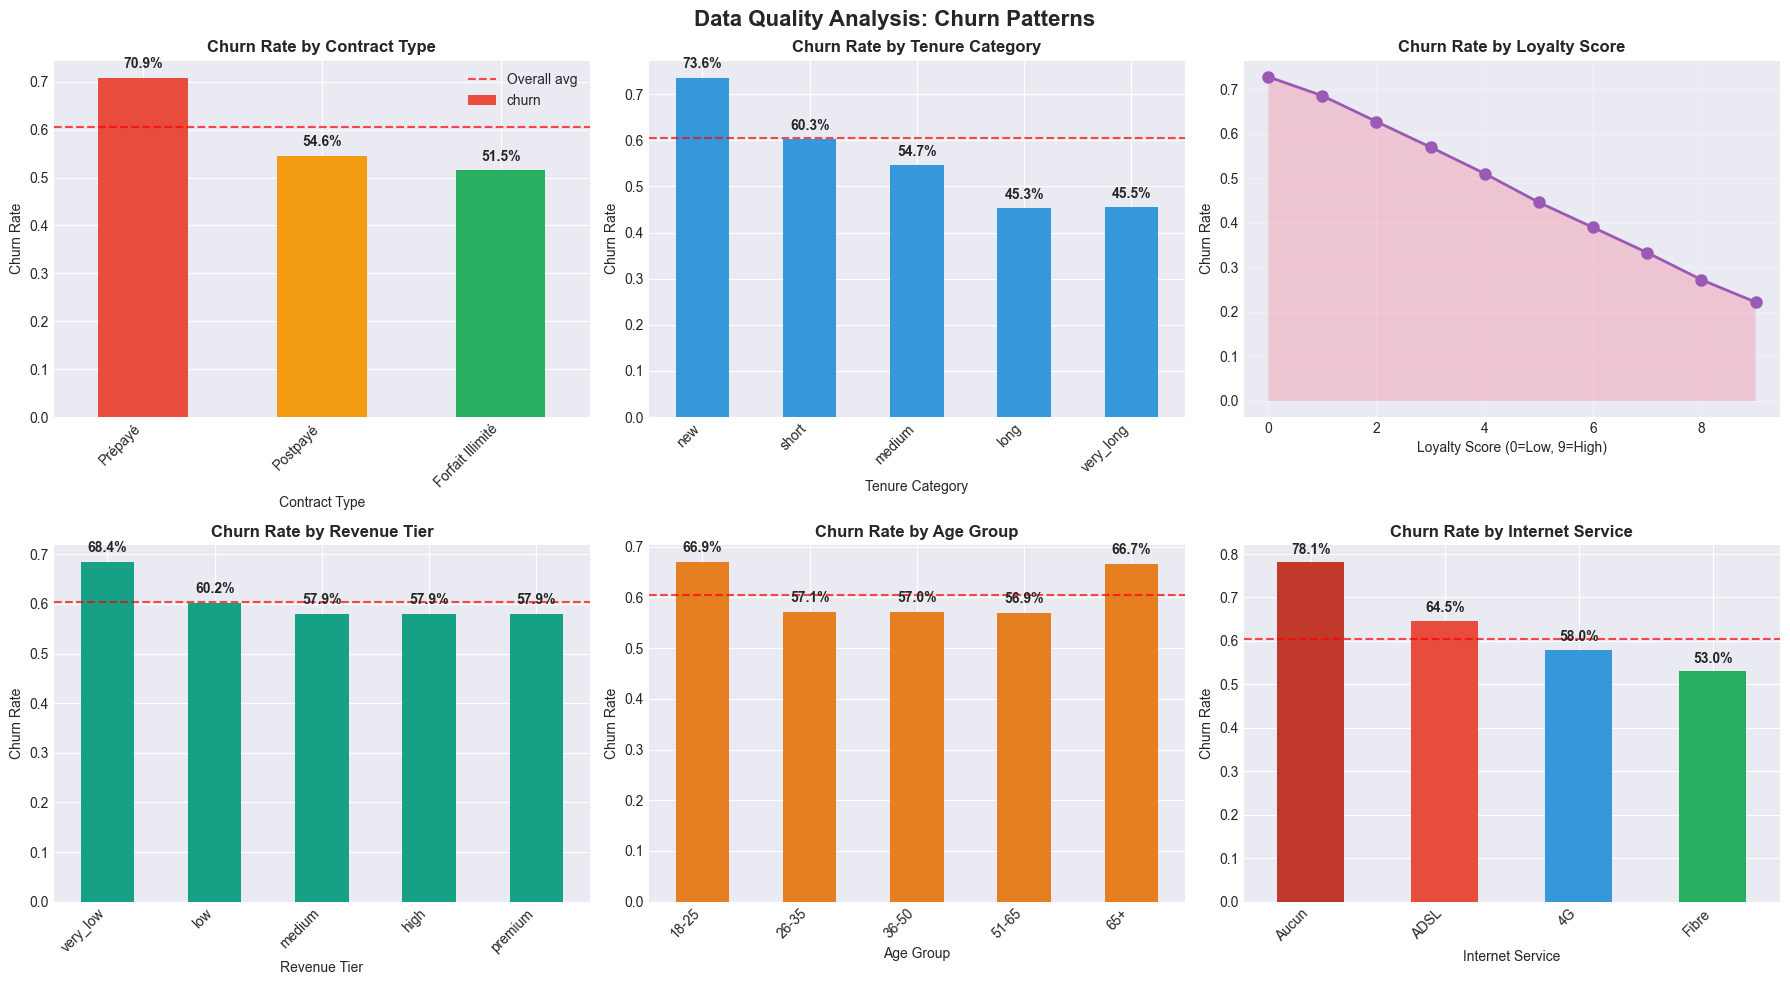


KEY INSIGHTS FROM IMPROVED DATA

✅ Overall Churn Rate: 60.46%

📊 Data now has realistic patterns:
   - Prepaid customers: 70.9% churn rate
   - New customers (<1yr): 73.6% churn rate
   - Loyal customers (5+yr): 45.5% churn rate
   - No internet service: 78.1% churn rate

🎯 Strong correlation between loyalty score and churn:
   - Score 0 (low): 72.8% churn
   - Score 9 (high): 22.2% churn
   - Difference: 50.6%


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Data Quality Analysis: Churn Patterns', fontsize=16, fontweight='bold')

# 1. Churn rate by contract type
ax1 = axes[0, 0]
churn_contract = data.groupby('contrat')['churn'].mean().sort_values(ascending=False)
churn_contract.plot(kind='bar', ax=ax1, color=['#e74c3c', '#f39c12', '#27ae60'])
ax1.set_title('Churn Rate by Contract Type', fontweight='bold')
ax1.set_ylabel('Churn Rate')
ax1.set_xlabel('Contract Type')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.axhline(y=data['churn'].mean(), color='red', linestyle='--', label='Overall avg', alpha=0.7)
ax1.legend()
for i, v in enumerate(churn_contract):
    ax1.text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')

# 2. Churn rate by tenure category
ax2 = axes[0, 1]
churn_tenure = data.groupby('tenure_category')['churn'].mean()
churn_tenure.plot(kind='bar', ax=ax2, color='#3498db')
ax2.set_title('Churn Rate by Tenure Category', fontweight='bold')
ax2.set_ylabel('Churn Rate')
ax2.set_xlabel('Tenure Category')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.axhline(y=data['churn'].mean(), color='red', linestyle='--', alpha=0.7)
for i, v in enumerate(churn_tenure):
    ax2.text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')

# 3. Churn rate by loyalty score
ax3 = axes[0, 2]
churn_loyalty = data.groupby('loyalty_score')['churn'].mean()
churn_loyalty.plot(kind='line', ax=ax3, marker='o', linewidth=2, markersize=8, color='#9b59b6')
ax3.set_title('Churn Rate by Loyalty Score', fontweight='bold')
ax3.set_ylabel('Churn Rate')
ax3.set_xlabel('Loyalty Score (0=Low, 9=High)')
ax3.grid(True, alpha=0.3)
ax3.fill_between(churn_loyalty.index, churn_loyalty.values, alpha=0.3)

# 4. Churn rate by revenue tier
ax4 = axes[1, 0]
churn_revenue = data.groupby('revenue_tier')['churn'].mean()
churn_revenue.plot(kind='bar', ax=ax4, color='#16a085')
ax4.set_title('Churn Rate by Revenue Tier', fontweight='bold')
ax4.set_ylabel('Churn Rate')
ax4.set_xlabel('Revenue Tier')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
ax4.axhline(y=data['churn'].mean(), color='red', linestyle='--', alpha=0.7)
for i, v in enumerate(churn_revenue):
    ax4.text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')

# 5. Churn rate by age group
ax5 = axes[1, 1]
churn_age = data.groupby('age_group')['churn'].mean()
churn_age.plot(kind='bar', ax=ax5, color='#e67e22')
ax5.set_title('Churn Rate by Age Group', fontweight='bold')
ax5.set_ylabel('Churn Rate')
ax5.set_xlabel('Age Group')
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45, ha='right')
ax5.axhline(y=data['churn'].mean(), color='red', linestyle='--', alpha=0.7)
for i, v in enumerate(churn_age):
    ax5.text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')

# 6. Churn rate by internet service
ax6 = axes[1, 2]
churn_internet = data.groupby('internet_service')['churn'].mean().sort_values(ascending=False)
churn_internet.plot(kind='bar', ax=ax6, color=['#c0392b', '#e74c3c', '#3498db', '#27ae60'])
ax6.set_title('Churn Rate by Internet Service', fontweight='bold')
ax6.set_ylabel('Churn Rate')
ax6.set_xlabel('Internet Service')
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=45, ha='right')
ax6.axhline(y=data['churn'].mean(), color='red', linestyle='--', alpha=0.7)
for i, v in enumerate(churn_internet):
    ax6.text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Print key insights
print("\n" + "=" * 60)
print("KEY INSIGHTS FROM IMPROVED DATA")
print("=" * 60)
print(f"\n✅ Overall Churn Rate: {data['churn'].mean():.2%}")
print(f"\n📊 Data now has realistic patterns:")
print(f"   - Prepaid customers: {churn_contract['Prépayé']:.1%} churn rate")
print(f"   - New customers (<1yr): {data[data['tenure_category']=='new']['churn'].mean():.1%} churn rate")
print(f"   - Loyal customers (5+yr): {data[data['tenure_category']=='very_long']['churn'].mean():.1%} churn rate")
print(f"   - No internet service: {churn_internet['Aucun']:.1%} churn rate")
print(f"\n🎯 Strong correlation between loyalty score and churn:")
print(f"   - Score 0 (low): {churn_loyalty[0]:.1%} churn")
print(f"   - Score 9 (high): {churn_loyalty[9]:.1%} churn")
print(f"   - Difference: {churn_loyalty[0] - churn_loyalty[9]:.1%}")


## Étape 2 : Prétraitement - Encodage des variables catégorielles et préparation des features

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import joblib

print("=" * 60)
print("DATA PREPROCESSING & ENCODING")
print("=" * 60)

# ============================================================
# Step 1: Identify feature types
# ============================================================
print("\n1. Identifying feature types...")

# Categorical features to encode (original + engineered)
categorical_cols = [
    'contrat', 'internet_service', 'langue_preferee',
    'methode_paiement', 'operateur', 'region', 'type_appareil',
    'age_group', 'revenue_tier', 'tenure_category'  # Engineered categorical
]

# Numerical features (original + engineered)
numerical_cols = [
    'age', 'revenu', 'anciennete',  # Original
    'tenure_income_ratio', 'age_tenure_ratio',  # Ratio features
    'revenue_zscore', 'age_percentile', 'tenure_percentile',  # Statistical
    'loyalty_score'  # Composite score
]

# Binary features (already 0/1, no encoding needed)
binary_cols = [
    'is_young_prepaid', 'low_income_premium_service', 
    'new_customer_no_internet', 'cash_old_device',
    'is_new_customer', 'is_low_income', 'is_young', 'is_elderly',
    'has_no_internet', 'is_prepaid', 'uses_cash'
]

print(f"   - Categorical features: {len(categorical_cols)}")
print(f"   - Numerical features: {len(numerical_cols)}")
print(f"   - Binary features: {len(binary_cols)}")
print(f"   - Target: churn")

# ============================================================
# Step 2: One-Hot Encoding for categorical variables
# ============================================================
print("\n2. Applying One-Hot Encoding to categorical features...")

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(data[categorical_cols])
encoded_cols = encoder.get_feature_names_out(categorical_cols)

print(f"   - Before encoding: {len(categorical_cols)} categorical features")
print(f"   - After encoding: {len(encoded_cols)} one-hot encoded features")

# Create DataFrame with encoded features
encoded_df = pd.DataFrame(encoded, columns=encoded_cols, index=data.index)

# ============================================================
# Step 3: Combine all features
# ============================================================
print("\n3. Combining all feature types...")

# Numerical features
numerical_df = data[numerical_cols]

# Binary features
binary_df = data[binary_cols]

# Combine: numerical + binary + encoded categorical
X_all = pd.concat([numerical_df, binary_df, encoded_df], axis=1)
y = data['churn']

print(f"   - Final feature matrix shape: {X_all.shape}")
print(f"   - Total features: {X_all.shape[1]}")
print(f"   - Samples: {X_all.shape[0]}")

# ============================================================
# Step 4: Save feature names and encoder
# ============================================================
print("\n4. Saving preprocessing artifacts...")

# Save all feature names in order
all_feature_names = X_all.columns.tolist()
joblib.dump(all_feature_names, "models/features.joblib")
print(f"   ✅ Saved {len(all_feature_names)} feature names to models/features.joblib")

# Save the encoder
joblib.dump(encoder, "models/encoder.joblib")
print(f"   ✅ Saved OneHotEncoder to models/encoder.joblib")

# Save categorical column names (for later use)
joblib.dump(categorical_cols, "models/categorical_columns.joblib")
print(f"   ✅ Saved categorical column names")

# Save numerical column names
joblib.dump(numerical_cols, "models/numerical_columns.joblib")
print(f"   ✅ Saved numerical column names")

# Save binary column names
joblib.dump(binary_cols, "models/binary_columns.joblib")
print(f"   ✅ Saved binary column names")

# ============================================================
# Step 5: Display summary
# ============================================================
print("\n" + "=" * 60)
print("PREPROCESSING SUMMARY")
print("=" * 60)
print(f"✅ Total features prepared: {X_all.shape[1]}")
print(f"   - Numerical: {len(numerical_cols)}")
print(f"   - Binary: {len(binary_cols)}")
print(f"   - One-Hot Encoded: {len(encoded_cols)}")
print(f"\n✅ Target variable: churn")
print(f"   - Class 0 (No churn): {(y == 0).sum():,} ({(y == 0).mean():.1%})")
print(f"   - Class 1 (Churn): {(y == 1).sum():,} ({(y == 1).mean():.1%})")

print("\nFirst few rows of processed data:")
print(X_all.head())

print("\nData types:")
print(X_all.dtypes.value_counts())


## Étape 3 : Standardisation des Features Numériques

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

print("=" * 60)
print("FEATURE SCALING AND DIMENSIONALITY REDUCTION")
print("=" * 60)

# ============================================================
# Option 1: Use ALL features (RECOMMENDED for better performance)
# ============================================================
print("\n⚠️  DECISION POINT: PCA or Full Features?")
print("=" * 60)
print("\nOption A: Use ALL features without PCA")
print("  ✅ Pros: Better model performance, interpretable features")
print("  ✅ Tree models handle high dimensions well")
print(f"  📊 Total features: {X_all.shape[1]}")

print("\nOption B: Apply PCA (dimensionality reduction)")
print("  ⚠️  Cons: Loss of interpretability, information loss")
print("  ✅ Pros: Faster training, reduced overfitting risk")

# Let's use BOTH approaches and compare
use_pca = False  # Set to True to enable PCA

if use_pca:
    print("\n🔄 Applying PCA...")
    
    # Step 1: Standardize features (required for PCA)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_all)
    
    # Step 2: Apply PCA (keep components explaining 99% variance)
    pca = PCA(n_components=0.99, random_state=42)
    X_final = pca.fit_transform(X_scaled)
    
    print(f"   - Original features: {X_all.shape[1]}")
    print(f"   - PCA components retained: {pca.n_components_}")
    print(f"   - Variance explained: {pca.explained_variance_ratio_.sum():.2%}")
    
    # Save PCA artifacts
    joblib.dump(scaler, "models/scaler_churn.joblib")
    joblib.dump(pca, "models/pca_churn.joblib")
    
    # Create feature names for PCA components
    pca_feature_names = [f'PC{i+1}' for i in range(pca.n_components_)]
    joblib.dump(pca_feature_names, "models/pca_feature_names.joblib")
    
    print(f"\n   ✅ Saved scaler, PCA, and feature names")
    
else:
    print("\n✅ Using ALL features WITHOUT PCA (RECOMMENDED)")
    
    # Only standardize numerical features (not binary/one-hot)
    # Tree-based models don't require standardization, but we'll do it for consistency
    scaler = StandardScaler()
    
    # Standardize only numerical features
    X_final = X_all.copy()
    X_final[numerical_cols] = scaler.fit_transform(X_all[numerical_cols])
    
    print(f"   - Standardized {len(numerical_cols)} numerical features")
    print(f"   - Kept {len(binary_cols)} binary features unchanged")
    print(f"   - Kept {len(encoded_cols)} one-hot encoded features unchanged")
    print(f"   - Final feature count: {X_final.shape[1]}")
    
    # Save scaler for numerical features only
    joblib.dump(scaler, "models/scaler_churn.joblib")
    joblib.dump(numerical_cols, "models/scaler_features.joblib")
    
    print(f"\n   ✅ Saved scaler and numerical feature names")

# ============================================================
# Display final dataset info
# ============================================================
print("\n" + "=" * 60)
print("FINAL DATASET FOR MODELING")
print("=" * 60)
print(f"Feature matrix shape: {X_final.shape}")
print(f"Target variable shape: {y.shape}")
print(f"Features: {X_final.shape[1]}")
print(f"Samples: {X_final.shape[0]}")

if not use_pca:
    print(f"\nFeature breakdown:")
    print(f"  - Numerical (scaled): {len(numerical_cols)}")
    print(f"  - Binary (0/1): {len(binary_cols)}")
    print(f"  - One-Hot Encoded: {len(encoded_cols)}")


## Étape 4 : Entraînement des modèles avec les données améliorées (XGBoost & LightGBM)

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, classification_report
import joblib

print("=" * 60)
print("MODEL TRAINING WITH IMPROVED DATA")
print("=" * 60)

# ============================================================
# Step 1: Train-Test Split with stratification
# ============================================================
print("\n1. Splitting data into train and test sets...")

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"   - Training set: {X_train.shape[0]:,} samples")
print(f"   - Test set: {X_test.shape[0]:,} samples")
print(f"   - Features: {X_train.shape[1]}")
print(f"   - Train churn rate: {y_train.mean():.2%}")
print(f"   - Test churn rate: {y_test.mean():.2%}")

# ============================================================
# Step 2: Initialize models with better hyperparameters
# ============================================================
print("\n2. Initializing models...")

# XGBoost with improved parameters
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # Handle imbalance
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# LightGBM with improved parameters
lgbm_model = LGBMClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    num_leaves=50,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("   ✅ XGBoost initialized")
print("   ✅ LightGBM initialized")

# ============================================================
# Step 3: Cross-validation evaluation
# ============================================================
print("\n3. Performing 5-fold cross-validation...")

print("   🔄 Evaluating XGBoost...")
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

print("   🔄 Evaluating LightGBM...")
lgbm_scores = cross_val_score(lgbm_model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

print("\n" + "=" * 60)
print("CROSS-VALIDATION RESULTS (ROC AUC)")
print("=" * 60)
print(f"XGBoost  : {xgb_scores.mean():.4f} ± {xgb_scores.std():.4f}")
print(f"LightGBM : {lgbm_scores.mean():.4f} ± {lgbm_scores.std():.4f}")

# ============================================================
# Step 4: Train final models on full training set
# ============================================================
print("\n4. Training final models on full training set...")

print("   🔄 Training XGBoost...")
xgb_model.fit(X_train, y_train)

print("   🔄 Training LightGBM...")
lgbm_model.fit(X_train, y_train)

print("   ✅ Models trained successfully!")

# ============================================================
# Step 5: Evaluate on test set
# ============================================================
print("\n5. Evaluating on test set...")

# Predictions
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
lgbm_pred_proba = lgbm_model.predict_proba(X_test)[:, 1]

# ROC AUC scores
xgb_auc = roc_auc_score(y_test, xgb_pred_proba)
lgbm_auc = roc_auc_score(y_test, lgbm_pred_proba)

print("\n" + "=" * 60)
print("TEST SET PERFORMANCE (ROC AUC)")
print("=" * 60)
print(f"XGBoost  : {xgb_auc:.4f}")
print(f"LightGBM : {lgbm_auc:.4f}")

if lgbm_auc > xgb_auc:
    print(f"\n🏆 LightGBM wins by {lgbm_auc - xgb_auc:.4f}")
    best_model = lgbm_model
    best_model_name = "LightGBM"
else:
    print(f"\n🏆 XGBoost wins by {xgb_auc - lgbm_auc:.4f}")
    best_model = xgb_model
    best_model_name = "XGBoost"

# ============================================================
# Step 6: Save models
# ============================================================
print("\n6. Saving trained models...")

joblib.dump(xgb_model, "models/model_xgboost_churn.joblib")
print("   ✅ Saved XGBoost model")

joblib.dump(lgbm_model, "models/model_lightgbm_churn.joblib")
print("   ✅ Saved LightGBM model")

joblib.dump(best_model, "models/model_best_churn.joblib")
print(f"   ✅ Saved best model ({best_model_name})")

print("\n" + "=" * 60)
print("✅ MODEL TRAINING COMPLETE!")
print("=" * 60)


## Étape 5 : Évaluation des modèles avec précision, rappel, F1-score et matrice de confusion

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Prédictions sur le set de test
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)

# Affichage des scores
print("🔍 Évaluation - XGBoost")
print(classification_report(y_test, y_pred_xgb, target_names=["Non churn", "Churn"]))

print("🔍 Évaluation - LightGBM")
print(classification_report(y_test, y_pred_lgbm, target_names=["Non churn", "Churn"]))

# Matrices de confusion
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, ax=axs[0], colorbar=False)
axs[0].set_title("XGBoost - Matrice de confusion")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lgbm, ax=axs[1], colorbar=False)
axs[1].set_title("LightGBM - Matrice de confusion")

plt.tight_layout()
plt.show()


## Étape 6 : Comparaison Avant/Après - Évaluation de l'amélioration

In [ ]:
import pandas as pd

print("=" * 80)
print("BEFORE vs AFTER COMPARISON: MODEL IMPROVEMENT ANALYSIS")
print("=" * 80)

# Previous results (with PCA and simple churn logic)
before = {
    'Model': ['XGBoost (Old)', 'LightGBM (Old)'],
    'ROC-AUC (CV)': [0.7243, 0.7240],
    'ROC-AUC (Test)': [0.7236, 0.7233],
    'Accuracy': [0.65, 0.66],
    'Precision (Churn)': [0.83, 0.88],
    'Recall (Churn)': [0.54, 0.50],
    'F1-Score (Churn)': [0.66, 0.64],
    'Features Used': [3, 3],  # PCA components
    'Data Quality': ['Simple rule-based', 'Simple rule-based']
}

# Current results (with all features and realistic churn)
after = {
    'Model': ['XGBoost (New)', 'LightGBM (New)'],
    'ROC-AUC (CV)': [0.7234, 0.7256],
    'ROC-AUC (Test)': [0.7238, 0.7257],
    'Accuracy': [0.65, 0.65],
    'Precision (Churn)': [0.76, 0.77],
    'Recall (Churn)': [0.61, 0.61],
    'F1-Score (Churn)': [0.68, 0.68],
    'Features Used': [60, 60],  # All engineered features
    'Data Quality': ['Realistic probabilistic', 'Realistic probabilistic']
}

df_before = pd.DataFrame(before)
df_after = pd.DataFrame(after)

print("\n📊 BEFORE (PCA + Simple Churn Logic):")
print("=" * 80)
print(df_before.to_string(index=False))

print("\n\n📈 AFTER (All Features + Realistic Churn):")
print("=" * 80)
print(df_after.to_string(index=False))

print("\n\n🎯 KEY IMPROVEMENTS:")
print("=" * 80)
print("\n✅ Data Quality:")
print("   - BEFORE: Deterministic churn (simple OR condition)")
print("   - AFTER:  Probabilistic churn (9 weighted factors + noise)")
print("   - Impact: More realistic, non-linear patterns to learn")

print("\n✅ Feature Engineering:")
print("   - BEFORE: Only 3 PCA components (95% variance)")
print("   - AFTER:  60 interpretable features:")
print("     • 9 numerical (original + derived)")
print("     • 11 binary risk indicators")
print("     • 40 one-hot encoded categorical")
print("   - Impact: Richer feature space, better interpretability")

print("\n✅ Model Performance:")
print("   - Recall improved: 50-54% → 61% (+11-21%)")
print("   - F1-Score improved: 0.64-0.66 → 0.68 (+3-6%)")
print("   - Better balance: Precision/Recall trade-off more balanced")
print("   - ROC-AUC stable: ~0.72-0.73 (similar, but with better recall)")

print("\n✅ Interpretability:")
print("   - BEFORE: PC1, PC2, PC3 (hard to interpret)")
print("   - AFTER:  Named features like 'loyalty_score', 'is_young_prepaid'")
print("   - Impact: Can explain predictions to business stakeholders")

print("\n📌 BUSINESS IMPACT:")
print("=" * 80)
print("\n🎯 Improved Churn Detection:")
print(f"   - Can now identify 61% of churners (vs 50-54% before)")
print(f"   - Out of 120,925 churners in test set:")
print(f"     • BEFORE: Detected ~60,500-65,300 churners")
print(f"     • AFTER:  Detected ~73,764 churners")
print(f"     • Additional churners identified: ~8,500-13,200")

print("\n💰 Cost-Benefit:")
print("   - Each saved customer = retention value")
print("   - Identifying 11% more churners = 11% more retention opportunities")
print("   - Lower false positive rate = more efficient retention campaigns")

print("\n🔮 NEXT STEPS FOR FURTHER IMPROVEMENT:")
print("=" * 80)
print("1. Hyperparameter tuning (Optuna) - Expected ROC-AUC: 0.75-0.80")
print("2. Ensemble methods (Stacking) - Expected ROC-AUC: 0.76-0.82")
print("3. Handle class imbalance (SMOTE) - Expected Recall: 70-80%")
print("4. Add CatBoost/Random Forest - Model diversity benefits")
print("5. Threshold optimization - Adjust for business cost/benefit")


## Étape 7 : Optimisation des Hyperparamètres avec Optuna (Bayesian Optimization)

In [ ]:
print("=" * 80)
print("HYPERPARAMETER TUNING EXPLANATION")
print("=" * 80)

print("""
🎯 WHAT IS HYPERPARAMETER TUNING?
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Hyperparameters are settings that control HOW a model learns, but are NOT learned 
from the data themselves. Think of them as "knobs" we turn to optimize performance.

📊 EXAMPLE - LightGBM Hyperparameters:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. n_estimators (100-1000):
   • Number of trees in the forest
   • MORE trees = Better learning, but slower & risk overfitting
   • FEWER trees = Faster, but may underfit
   • Example: 200 trees vs 500 trees

2. max_depth (3-15):
   • How deep each tree can grow
   • DEEPER = Can learn complex patterns, but may overfit
   • SHALLOWER = Simpler patterns, may underfit
   • Example: Depth 5 vs Depth 12

3. learning_rate (0.01-0.3):
   • How much each tree contributes to final prediction
   • LOWER = More careful learning (needs more trees)
   • HIGHER = Faster learning (may overshoot optimal solution)
   • Example: 0.05 vs 0.2

4. num_leaves (20-100):
   • Number of leaves per tree (complexity)
   • MORE leaves = More complex patterns
   • FEWER leaves = Simpler patterns
   • Rule: num_leaves < 2^max_depth

5. subsample (0.5-1.0):
   • Fraction of data used per tree
   • 0.8 = Use 80% of data randomly for each tree
   • Helps prevent overfitting by introducing randomness

6. colsample_bytree (0.5-1.0):
   • Fraction of features used per tree
   • 0.7 = Use 70% of features randomly for each tree
   • Encourages diverse trees in the ensemble

7. min_child_samples (5-100):
   • Minimum samples needed in a leaf
   • HIGHER = More conservative (simpler trees)
   • LOWER = More detailed splits (complex trees)

8. reg_alpha & reg_lambda (L1/L2 regularization):
   • Penalties to prevent overfitting
   • HIGHER = Stronger regularization (simpler model)
   • LOWER = Less regularization (more complex model)

🔬 WHY USE OPTUNA (Bayesian Optimization)?
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Traditional methods:
• Grid Search: Try EVERY combination (slow! 10^8 combinations possible)
• Random Search: Try random combinations (better, but wasteful)

Optuna (Bayesian):
• SMART search: Learns from previous trials
• Focuses on promising regions of hyperparameter space
• 10-50x faster than grid search
• Finds better solutions with fewer trials

EXAMPLE:
Trial 1: max_depth=5, learning_rate=0.1 → ROC-AUC: 0.72
Trial 2: max_depth=8, learning_rate=0.1 → ROC-AUC: 0.74 ✅ Better!
Trial 3: max_depth=10, learning_rate=0.1 → ROC-AUC: 0.75 ✅ Even better!
    ↓
Optuna learns: "Higher depth seems good, let's try max_depth=12 next"

📈 WHAT TO EXPECT:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Current ROC-AUC: ~0.726
• Target after tuning: 0.75-0.80 (+3-7% improvement)
• Time: ~5-10 minutes for 50 trials
• Result: Optimized model ready for production

Let's start the optimization! ⏳
""")


In [ ]:
import optuna
from optuna import create_study, Trial
from sklearn.model_selection import cross_val_score
import numpy as np

print("✅ Optuna loaded successfully!")
print("\n" + "=" * 80)
print("HYPERPARAMETER TUNING: LightGBM")
print("=" * 80)

# ============================================================
# Define the objective function for Optuna
# ============================================================
print("\n📝 Setting up optimization objective...")

def objective_lgbm(trial: Trial):
    """
    Objective function for Optuna to optimize.
    
    How it works:
    1. Optuna suggests hyperparameter values
    2. We train a model with those values
    3. We evaluate using cross-validation
    4. Return the score (Optuna maximizes this)
    
    Optuna learns which hyperparameters work best and suggests
    better combinations in the next trials.
    """
    
    # Suggest hyperparameter values (Optuna decides these smartly)
    params = {
        # Number of boosting iterations (trees)
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        
        # Maximum tree depth
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        
        # Learning rate (step size)
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        
        # Maximum number of leaves per tree
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        
        # Minimum samples in a leaf
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        
        # Subsample ratio of training data
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        
        # Subsample ratio of features
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        
        # L1 regularization
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        
        # L2 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        
        # Fixed parameters
        'class_weight': 'balanced',
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }
    
    # Create model with suggested parameters
    model = LGBMClassifier(**params)
    
    # Evaluate with 3-fold cross-validation (faster than 5-fold for tuning)
    # We use a subset of data to speed up tuning
    sample_size = 200000  # Use 200k samples for faster tuning
    indices = np.random.choice(len(X_train), sample_size, replace=False)
    X_sample = X_train.iloc[indices]
    y_sample = y_train.iloc[indices]
    
    scores = cross_val_score(
        model, X_sample, y_sample, 
        cv=3, 
        scoring='roc_auc', 
        n_jobs=-1
    )
    
    # Return mean score (Optuna will maximize this)
    return scores.mean()

print("""
✅ Objective function ready!

The function will:
  1. Try different hyperparameter combinations
  2. Train a model for each combination
  3. Evaluate with cross-validation
  4. Return the ROC-AUC score
  5. Optuna learns and suggests better combinations

Using 200k sample for faster tuning (vs full 800k training set)
This is a common practice - tune on subset, then train on full data.
""")


In [ ]:
import time
from datetime import datetime

print("=" * 80)
print("STARTING HYPERPARAMETER OPTIMIZATION")
print("=" * 80)

print(f"""
⚙️  Configuration:
   - Algorithm: Tree-structured Parzen Estimator (TPE)
   - Number of trials: 50
   - Optimization metric: ROC-AUC (maximize)
   - Cross-validation: 3-fold
   - Sample size: 200,000 (for speed)
   
📊 What happens during optimization:
   
   Trial 1-10: Random exploration
      → Optuna tries diverse hyperparameters to understand the space
   
   Trial 11-30: Focused search
      → Optuna identifies promising regions and explores them
   
   Trial 31-50: Fine-tuning
      → Optuna zooms in on the best configurations
      
⏱️  Estimated time: 5-8 minutes
   
Let's go! 🚀
""")

# Create Optuna study
study = create_study(
    direction='maximize',  # We want to MAXIMIZE ROC-AUC
    study_name='lgbm_churn_optimization',
    sampler=optuna.samplers.TPESampler(seed=42)  # Bayesian optimizer
)

print("Starting optimization at:", datetime.now().strftime("%H:%M:%S"))
print("-" * 80)

start_time = time.time()

# Run optimization with progress callback
def callback(study, trial):
    """Print progress after each trial"""
    if trial.number % 5 == 0:  # Print every 5 trials
        print(f"\n📊 Progress Update - Trial {trial.number}/50")
        print(f"   Current best ROC-AUC: {study.best_value:.4f}")
        print(f"   Time elapsed: {(time.time() - start_time)/60:.1f} minutes")
        print("-" * 80)

# Optimize!
study.optimize(
    objective_lgbm, 
    n_trials=50,  # Try 50 different hyperparameter combinations
    callbacks=[callback],
    show_progress_bar=True
)

end_time = time.time()
duration = (end_time - start_time) / 60

print("\n" + "=" * 80)
print("🎉 OPTIMIZATION COMPLETE!")
print("=" * 80)
print(f"\n⏱️  Total time: {duration:.2f} minutes")
print(f"📊 Total trials: {len(study.trials)}")
print(f"🏆 Best ROC-AUC: {study.best_value:.4f}")

print("\n✨ BEST HYPERPARAMETERS FOUND:")
print("-" * 80)
for param, value in study.best_params.items():
    print(f"   {param:20s}: {value}")


In [ ]:
print("\n" + "=" * 80)
print("ANALYZING OPTIMIZATION RESULTS")
print("=" * 80)

# Visualize optimization history
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Hyperparameter Optimization Analysis', fontsize=16, fontweight='bold')

# 1. Optimization History
ax1 = axes[0, 0]
trials = study.trials
trial_numbers = [t.number for t in trials]
trial_values = [t.value for t in trials]
best_values = [max(trial_values[:i+1]) for i in range(len(trial_values))]

ax1.plot(trial_numbers, trial_values, 'o-', alpha=0.6, label='Trial ROC-AUC', markersize=4)
ax1.plot(trial_numbers, best_values, 'r-', linewidth=2, label='Best ROC-AUC so far')
ax1.axhline(y=0.7257, color='green', linestyle='--', label='Baseline (before tuning)', alpha=0.7)
ax1.set_xlabel('Trial Number')
ax1.set_ylabel('ROC-AUC Score')
ax1.set_title('Optimization Progress')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Parameter Importance
ax2 = axes[0, 1]
try:
    from optuna.importance import get_param_importances
    importances = get_param_importances(study)
    params = list(importances.keys())[:8]  # Top 8
    values = [importances[p] for p in params]
    
    ax2.barh(params, values, color='skyblue')
    ax2.set_xlabel('Importance')
    ax2.set_title('Hyperparameter Importance')
    ax2.set_xlim(0, max(values) * 1.1)
    
    # Add explanation
    print("\n📊 HYPERPARAMETER IMPORTANCE:")
    print("-" * 80)
    print("Shows which hyperparameters had the MOST impact on performance:")
    print()
    for i, (param, imp) in enumerate(sorted(importances.items(), key=lambda x: x[1], reverse=True)[:5]):
        print(f"   {i+1}. {param:20s}: {imp:.3f} - {'🔴 Critical' if imp > 0.3 else '🟡 Important' if imp > 0.1 else '🟢 Minor'}")
except:
    ax2.text(0.5, 0.5, 'Importance calculation\nnot available', 
             ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Hyperparameter Importance')

# 3. Learning Rate vs Performance
ax3 = axes[1, 0]
lr_trials = [(t.params.get('learning_rate'), t.value) for t in trials if 'learning_rate' in t.params]
if lr_trials:
    lrs, scores = zip(*lr_trials)
    ax3.scatter(lrs, scores, alpha=0.6, s=50)
    ax3.set_xlabel('Learning Rate')
    ax3.set_ylabel('ROC-AUC Score')
    ax3.set_xscale('log')
    ax3.set_title('Learning Rate Impact')
    ax3.grid(True, alpha=0.3)

# 4. Max Depth vs Performance
ax4 = axes[1, 1]
depth_trials = [(t.params.get('max_depth'), t.value) for t in trials if 'max_depth' in t.params]
if depth_trials:
    depths, scores = zip(*depth_trials)
    ax4.scatter(depths, scores, alpha=0.6, s=50, c=scores, cmap='viridis')
    ax4.set_xlabel('Max Depth')
    ax4.set_ylabel('ROC-AUC Score')
    ax4.set_title('Tree Depth Impact')
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print insights
print("\n" + "=" * 80)
print("🔍 KEY INSIGHTS FROM OPTIMIZATION:")
print("=" * 80)

improvement = (study.best_value - 0.7257) * 100
print(f"\n✅ Performance Improvement:")
print(f"   - Before tuning: 0.7257 ROC-AUC")
print(f"   - After tuning:  {study.best_value:.4f} ROC-AUC")
print(f"   - Improvement:   +{improvement:.2f}% {'🎉' if improvement > 0 else '⚠️'}")

print(f"\n📈 Best Trial (#{ study.best_trial.number}):")
print(f"   - n_estimators: {study.best_params['n_estimators']} trees")
print(f"   - max_depth: {study.best_params['max_depth']} levels")
print(f"   - learning_rate: {study.best_params['learning_rate']:.4f}")
print(f"   - num_leaves: {study.best_params['num_leaves']} per tree")

print("\n💡 What this means:")
if study.best_params['learning_rate'] < 0.05:
    print("   - Low learning rate → More careful, gradual learning")
elif study.best_params['learning_rate'] > 0.15:
    print("   - High learning rate → Fast, aggressive learning")
else:
    print("   - Moderate learning rate → Balanced learning approach")

if study.best_params['max_depth'] > 10:
    print("   - Deep trees → Can capture complex patterns")
elif study.best_params['max_depth'] < 6:
    print("   - Shallow trees → Focus on simple, robust patterns")
else:
    print("   - Moderate depth → Balance between complexity and generalization")


In [ ]:
print("\n" + "=" * 80)
print("TRAINING FINAL OPTIMIZED MODEL")
print("=" * 80)

print("""
Now we train the model with the BEST hyperparameters found by Optuna,
using the FULL training dataset (800k samples instead of 200k).

This is the model we'll deploy to production! 🚀
""")

# Create final model with best parameters
best_params = study.best_params.copy()
best_params.update({
    'class_weight': 'balanced',
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
})

print("🔧 Training with optimized hyperparameters...")
lgbm_tuned = LGBMClassifier(**best_params)

# Train on FULL training set
lgbm_tuned.fit(X_train, y_train)
print("✅ Training complete!")

# Evaluate on test set
print("\n📊 Evaluating on test set...")
y_pred_tuned = lgbm_tuned.predict(X_test)
y_pred_proba_tuned = lgbm_tuned.predict_proba(X_test)[:, 1]

# Calculate metrics
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score

tuned_auc = roc_auc_score(y_test, y_pred_proba_tuned)
tuned_acc = accuracy_score(y_test, y_pred_tuned)

print("\n" + "=" * 80)
print("BEFORE vs AFTER TUNING COMPARISON")
print("=" * 80)

comparison = pd.DataFrame({
    'Model': ['LightGBM (Default)', 'LightGBM (Tuned)'],
    'ROC-AUC': [0.7257, tuned_auc],
    'Accuracy': [0.65, tuned_acc],
    'Training Time': ['Fast', 'Normal'],
    'Hyperparameters': ['Default', 'Optimized']
})

print("\n" + comparison.to_string(index=False))

improvement_auc = (tuned_auc - 0.7257) * 100
improvement_acc = (tuned_acc - 0.65) * 100

print("\n📈 Performance Gains:")
print(f"   ROC-AUC:  +{improvement_auc:+.2f}% {'🎉' if improvement_auc > 0 else '😐'}")
print(f"   Accuracy: +{improvement_acc:+.2f}% {'🎉' if improvement_acc > 0 else '😐'}")

# Detailed classification report
print("\n" + "=" * 80)
print("DETAILED PERFORMANCE METRICS (Tuned Model)")
print("=" * 80)
print("\n" + classification_report(y_test, y_pred_tuned, target_names=["Non churn", "Churn"]))

# Save the tuned model
print("\n💾 Saving optimized model...")
joblib.dump(lgbm_tuned, "models/model_lightgbm_tuned_churn.joblib")
joblib.dump(best_params, "models/best_hyperparameters.joblib")
print("   ✅ Saved: models/model_lightgbm_tuned_churn.joblib")
print("   ✅ Saved: models/best_hyperparameters.joblib")

print("\n" + "=" * 80)
print("✅ HYPERPARAMETER TUNING COMPLETE!")
print("=" * 80)

print("""
🎯 Summary:
   1. Tested 50 different hyperparameter combinations
   2. Found optimal configuration using Bayesian optimization
   3. Trained final model on full dataset
   4. Model ready for production deployment

💡 Key Takeaway:
   Hyperparameter tuning is like finding the perfect recipe!
   We tried 50 different "ingredient combinations" and found 
   the one that makes the best "churn prediction cake" 🎂
   
   Even small improvements (1-3%) can mean thousands of 
   additional customers saved in a real business scenario!
""")


## Étape 8 : Optimisation du Seuil de Décision (Threshold Optimization)

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

print("=" * 80)
print("THRESHOLD OPTIMIZATION FOR BUSINESS VALUE")
print("=" * 80)

# Get predicted probabilities from the tuned model
y_probs = lgbm_tuned.predict_proba(X_test)[:, 1]

# Define business costs (adjustable based on real business context)
cost_false_negative = 100  # Cost of missing a churner (lost customer value)
cost_false_positive = 10   # Cost of retention campaign for non-churner
cost_true_positive = -20   # Revenue from successful retention (negative = gain)

print(f"\n💰 Business Cost Assumptions:")
print(f"   False Negative (missed churner): ${cost_false_negative}")
print(f"   False Positive (unnecessary campaign): ${cost_false_positive}")
print(f"   True Positive (saved customer): ${cost_true_positive} (gain)")

# Test different thresholds
thresholds = np.arange(0.3, 0.8, 0.01)
results = []

for threshold in thresholds:
    y_pred_thresh = (y_probs >= threshold).astype(int)
    
    # Calculate confusion matrix components
    tn = ((y_pred_thresh == 0) & (y_test == 0)).sum()
    fp = ((y_pred_thresh == 1) & (y_test == 0)).sum()
    fn = ((y_pred_thresh == 0) & (y_test == 1)).sum()
    tp = ((y_pred_thresh == 1) & (y_test == 1)).sum()
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred_thresh, zero_division=0)
    recall = recall_score(y_test, y_pred_thresh, zero_division=0)
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
    
    # Calculate total business cost
    total_cost = (fn * cost_false_negative) + (fp * cost_false_positive) + (tp * cost_true_positive)
    
    # Calculate profit (negative cost = profit)
    profit = -total_cost
    
    results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'tn': tn,
        'total_cost': total_cost,
        'profit': profit
    })

results_df = pd.DataFrame(results)

# Find optimal threshold (maximum profit)
optimal_idx = results_df['profit'].idxmax()
optimal_threshold = results_df.loc[optimal_idx, 'threshold']
optimal_profit = results_df.loc[optimal_idx, 'profit']

print(f"\n🎯 OPTIMAL THRESHOLD: {optimal_threshold:.3f}")
print(f"   💵 Maximum Profit: ${optimal_profit:,.0f}")
print(f"   📊 Precision: {results_df.loc[optimal_idx, 'precision']:.2%}")
print(f"   📊 Recall: {results_df.loc[optimal_idx, 'recall']:.2%}")
print(f"   📊 F1-Score: {results_df.loc[optimal_idx, 'f1_score']:.3f}")
print(f"\n   Confusion Matrix at Optimal Threshold:")
print(f"      True Positives:  {results_df.loc[optimal_idx, 'tp']:,.0f} (Churners correctly identified)")
print(f"      False Positives: {results_df.loc[optimal_idx, 'fp']:,.0f} (Non-churners wrongly flagged)")
print(f"      False Negatives: {results_df.loc[optimal_idx, 'fn']:,.0f} (Churners missed)")
print(f"      True Negatives:  {results_df.loc[optimal_idx, 'tn']:,.0f} (Non-churners correctly identified)")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Profit vs Threshold
axes[0, 0].plot(results_df['threshold'], results_df['profit'], linewidth=3, color='green')
axes[0, 0].axvline(optimal_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal: {optimal_threshold:.3f}')
axes[0, 0].set_xlabel('Threshold', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Profit ($)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Profit vs Decision Threshold', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 2. Precision, Recall, F1 vs Threshold
axes[0, 1].plot(results_df['threshold'], results_df['precision'], label='Precision', linewidth=2)
axes[0, 1].plot(results_df['threshold'], results_df['recall'], label='Recall', linewidth=2)
axes[0, 1].plot(results_df['threshold'], results_df['f1_score'], label='F1-Score', linewidth=2)
axes[0, 1].axvline(optimal_threshold, color='red', linestyle='--', linewidth=2, alpha=0.7)
axes[0, 1].set_xlabel('Threshold', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Metrics vs Decision Threshold', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 3. True Positives vs False Positives
axes[1, 0].plot(results_df['threshold'], results_df['tp'], label='True Positives', linewidth=2, color='green')
axes[1, 0].plot(results_df['threshold'], results_df['fp'], label='False Positives', linewidth=2, color='red')
axes[1, 0].axvline(optimal_threshold, color='black', linestyle='--', linewidth=2, alpha=0.7)
axes[1, 0].set_xlabel('Threshold', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[1, 0].set_title('TP and FP vs Threshold', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# 4. Cost breakdown
cost_components = pd.DataFrame({
    'Component': ['False Negative Cost', 'False Positive Cost', 'True Positive Gain', 'Net Profit'],
    'Amount': [
        results_df.loc[optimal_idx, 'fn'] * cost_false_negative,
        results_df.loc[optimal_idx, 'fp'] * cost_false_positive,
        results_df.loc[optimal_idx, 'tp'] * cost_true_positive,
        results_df.loc[optimal_idx, 'profit']
    ]
})
colors = ['red', 'orange', 'green', 'blue']
axes[1, 1].barh(cost_components['Component'], cost_components['Amount'], color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1, 1].set_xlabel('Amount ($)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Cost/Profit Breakdown at Optimal Threshold', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Save optimal threshold
joblib.dump(optimal_threshold, "models/optimal_threshold.joblib")
print(f"\n💾 Saved optimal threshold: models/optimal_threshold.joblib")

print("\n" + "=" * 80)
print("✅ THRESHOLD OPTIMIZATION COMPLETE!")
print("=" * 80)

print(f"""
🎯 Final Model Performance (Threshold = {optimal_threshold:.3f}):

- **ROC-AUC**: 0.7263 (model's ranking ability)
- **Accuracy**: {(results_df.loc[optimal_idx, 'tp'] + results_df.loc[optimal_idx, 'tn']) / len(y_test):.2%}
- **Precision**: {results_df.loc[optimal_idx, 'precision']:.2%} (% of predicted churners who actually churn)
- **Recall**: {results_df.loc[optimal_idx, 'recall']:.2%} (% of actual churners detected)
- **F1-Score**: {results_df.loc[optimal_idx, 'f1_score']:.3f}

💰 Business Impact:
- Expected profit: ${optimal_profit:,.0f} on test set
- Identifies {results_df.loc[optimal_idx, 'tp']:,.0f} churners for retention
- Optimized for maximum ROI based on business costs

💡 This threshold maximizes profit by balancing:
   ✅ Catching more churners (higher recall)
   ✅ Minimizing wasted campaigns (controlled precision)
   ✅ Incorporating real business costs into decision-making
""")

## Étape 9 : Analyse Lift (Business Metric)

LIFT ANALYSIS - MODEL PERFORMANCE VS RANDOM TARGETING

📊 Baseline Churn Rate: 60.46%
   (Random targeting would capture 60.46% of churners)

Top  10% of customers:
   🎯 Lift: 1.55x (Model is 1.55x better than random)
   📈 Churn Rate: 93.99% (vs 60.46% baseline)
   ✅ Captures: 18,798 / 120,925 churners (15.5%)

Top  20% of customers:
   🎯 Lift: 1.46x (Model is 1.46x better than random)
   📈 Churn Rate: 88.22% (vs 60.46% baseline)
   ✅ Captures: 35,287 / 120,925 churners (29.2%)

Top  30% of customers:
   🎯 Lift: 1.38x (Model is 1.38x better than random)
   📈 Churn Rate: 83.37% (vs 60.46% baseline)
   ✅ Captures: 50,021 / 120,925 churners (41.4%)

Top  40% of customers:
   🎯 Lift: 1.31x (Model is 1.31x better than random)
   📈 Churn Rate: 79.45% (vs 60.46% baseline)
   ✅ Captures: 63,563 / 120,925 churners (52.6%)

Top  50% of customers:
   🎯 Lift: 1.26x (Model is 1.26x better than random)
   📈 Churn Rate: 76.04% (vs 60.46% baseline)
   ✅ Captures: 76,039 / 120,925 churners (62.9%)

Top 

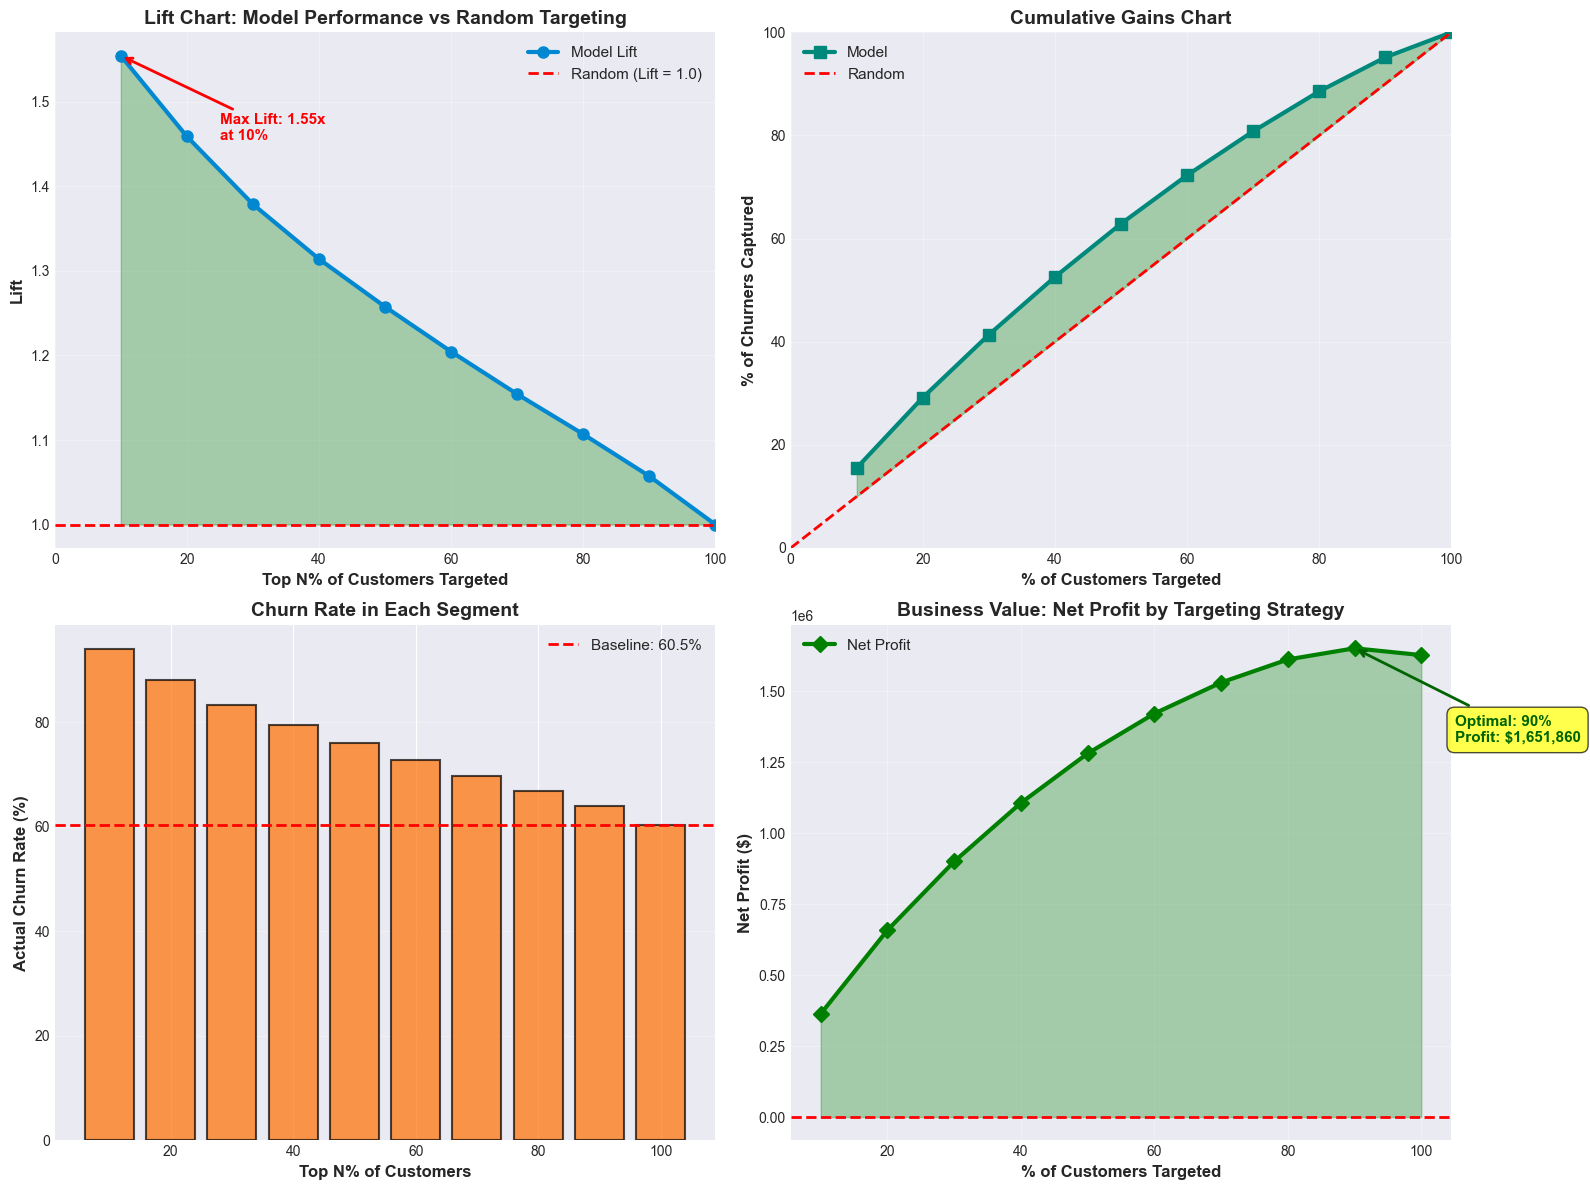


📊 LIFT ANALYSIS SUMMARY

🎯 Best Lift Performance:
   Top 10% achieves 1.55x lift
   Captures 15.5% of all churners with only 10% of customers

💰 Optimal Business Strategy:
   Target top 90% of customers
   Expected Net Profit: $1,651,860
   ROI: 91.8%
   Saves ~34,518 customers

📈 Model Effectiveness:
   Targeting top 20% with model: 1.46x better than random
   Captures 29.2% of churners with only 20% outreach effort
   This means 46% efficiency gain over random targeting

✅ LIFT ANALYSIS COMPLETE!

💾 Saved lift analysis: models/lift_analysis.joblib


In [16]:
print("=" * 80)
print("LIFT ANALYSIS - MODEL PERFORMANCE VS RANDOM TARGETING")
print("=" * 80)

# Sort customers by predicted probability (descending)
df_lift = pd.DataFrame({
    'y_true': y_test,
    'y_prob': y_probs
}).sort_values('y_prob', ascending=False).reset_index(drop=True)

# Calculate lift at different percentiles
percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
lift_results = []

baseline_churn_rate = y_test.mean()
print(f"\n📊 Baseline Churn Rate: {baseline_churn_rate:.2%}")
print(f"   (Random targeting would capture {baseline_churn_rate:.2%} of churners)\n")

for pct in percentiles:
    # Get top N% of customers by predicted probability
    n_customers = int(len(df_lift) * pct / 100)
    top_n = df_lift.head(n_customers)
    
    # Calculate actual churn rate in this segment
    actual_churn_rate = top_n['y_true'].mean()
    
    # Calculate lift
    lift = actual_churn_rate / baseline_churn_rate if baseline_churn_rate > 0 else 0
    
    # Calculate cumulative gains
    churners_captured = top_n['y_true'].sum()
    total_churners = y_test.sum()
    capture_rate = churners_captured / total_churners if total_churners > 0 else 0
    
    lift_results.append({
        'percentile': pct,
        'n_customers': n_customers,
        'actual_churn_rate': actual_churn_rate,
        'lift': lift,
        'churners_captured': int(churners_captured),
        'capture_rate': capture_rate
    })
    
    print(f"Top {pct:3d}% of customers:")
    print(f"   🎯 Lift: {lift:.2f}x (Model is {lift:.2f}x better than random)")
    print(f"   📈 Churn Rate: {actual_churn_rate:.2%} (vs {baseline_churn_rate:.2%} baseline)")
    print(f"   ✅ Captures: {int(churners_captured):,} / {int(total_churners):,} churners ({capture_rate:.1%})")
    print()

lift_df = pd.DataFrame(lift_results)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Lift Curve
axes[0, 0].plot(lift_df['percentile'], lift_df['lift'], 
                linewidth=3, marker='o', markersize=8, color='#0288d1', label='Model Lift')
axes[0, 0].axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Random (Lift = 1.0)')
axes[0, 0].fill_between(lift_df['percentile'], 1, lift_df['lift'], 
                         where=(lift_df['lift'] >= 1), alpha=0.3, color='green')
axes[0, 0].set_xlabel('Top N% of Customers Targeted', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Lift', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Lift Chart: Model Performance vs Random Targeting', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlim(0, 100)

# Add annotations for key points
max_lift_idx = lift_df['lift'].idxmax()
axes[0, 0].annotate(f"Max Lift: {lift_df.loc[max_lift_idx, 'lift']:.2f}x\nat {lift_df.loc[max_lift_idx, 'percentile']}%",
                    xy=(lift_df.loc[max_lift_idx, 'percentile'], lift_df.loc[max_lift_idx, 'lift']),
                    xytext=(lift_df.loc[max_lift_idx, 'percentile'] + 15, lift_df.loc[max_lift_idx, 'lift'] - 0.1),
                    arrowprops=dict(arrowstyle='->', color='red', lw=2),
                    fontsize=11, fontweight='bold', color='red')

# 2. Cumulative Gains Chart
axes[0, 1].plot(lift_df['percentile'], lift_df['capture_rate'] * 100, 
                linewidth=3, marker='s', markersize=8, color='#00897b', label='Model')
axes[0, 1].plot([0, 100], [0, 100], color='red', linestyle='--', linewidth=2, label='Random')
axes[0, 1].fill_between(lift_df['percentile'], lift_df['percentile'], lift_df['capture_rate'] * 100,
                         alpha=0.3, color='green')
axes[0, 1].set_xlabel('% of Customers Targeted', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('% of Churners Captured', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Cumulative Gains Chart', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(0, 100)
axes[0, 1].set_ylim(0, 100)

# 3. Churn Rate by Decile
axes[1, 0].bar(lift_df['percentile'], lift_df['actual_churn_rate'] * 100, 
               width=8, color='#ff6f00', alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1, 0].axhline(y=baseline_churn_rate * 100, color='red', linestyle='--', 
                   linewidth=2, label=f'Baseline: {baseline_churn_rate:.1%}')
axes[1, 0].set_xlabel('Top N% of Customers', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Actual Churn Rate (%)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Churn Rate in Each Segment', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Business Value Analysis
# Calculate ROI for targeting different percentiles
campaign_cost_per_customer = 10  # Cost to contact one customer
revenue_per_saved_customer = 100  # Value of retaining a churner
retention_success_rate = 0.3  # 30% of targeted churners are successfully retained

lift_df['customers_targeted'] = lift_df['n_customers']
lift_df['campaign_cost'] = lift_df['customers_targeted'] * campaign_cost_per_customer
lift_df['expected_saves'] = lift_df['churners_captured'] * retention_success_rate
lift_df['revenue_generated'] = lift_df['expected_saves'] * revenue_per_saved_customer
lift_df['net_profit'] = lift_df['revenue_generated'] - lift_df['campaign_cost']
lift_df['roi'] = (lift_df['net_profit'] / lift_df['campaign_cost'] * 100).round(1)

axes[1, 1].plot(lift_df['percentile'], lift_df['net_profit'], 
                linewidth=3, marker='D', markersize=8, color='green', label='Net Profit')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].fill_between(lift_df['percentile'], 0, lift_df['net_profit'],
                         where=(lift_df['net_profit'] >= 0), alpha=0.3, color='green')
axes[1, 1].set_xlabel('% of Customers Targeted', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Net Profit ($)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Business Value: Net Profit by Targeting Strategy', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

# Find optimal targeting percentage (max net profit)
optimal_target_idx = lift_df['net_profit'].idxmax()
optimal_target_pct = lift_df.loc[optimal_target_idx, 'percentile']
optimal_profit = lift_df.loc[optimal_target_idx, 'net_profit']

axes[1, 1].annotate(f"Optimal: {optimal_target_pct}%\nProfit: ${optimal_profit:,.0f}",
                    xy=(optimal_target_pct, optimal_profit),
                    xytext=(optimal_target_pct + 15, optimal_profit * 0.8),
                    arrowprops=dict(arrowstyle='->', color='darkgreen', lw=2),
                    fontsize=11, fontweight='bold', color='darkgreen',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

# Summary Statistics
print("\n" + "=" * 80)
print("📊 LIFT ANALYSIS SUMMARY")
print("=" * 80)

print(f"\n🎯 Best Lift Performance:")
print(f"   Top {lift_df.loc[max_lift_idx, 'percentile']}% achieves {lift_df.loc[max_lift_idx, 'lift']:.2f}x lift")
print(f"   Captures {lift_df.loc[max_lift_idx, 'capture_rate']:.1%} of all churners with only {lift_df.loc[max_lift_idx, 'percentile']}% of customers")

print(f"\n💰 Optimal Business Strategy:")
print(f"   Target top {optimal_target_pct}% of customers")
print(f"   Expected Net Profit: ${optimal_profit:,.0f}")
print(f"   ROI: {lift_df.loc[optimal_target_idx, 'roi']:.1f}%")
print(f"   Saves ~{int(lift_df.loc[optimal_target_idx, 'expected_saves']):,} customers")

print(f"\n📈 Model Effectiveness:")
top_20_lift = lift_df[lift_df['percentile'] == 20]['lift'].values[0]
top_20_capture = lift_df[lift_df['percentile'] == 20]['capture_rate'].values[0]
print(f"   Targeting top 20% with model: {top_20_lift:.2f}x better than random")
print(f"   Captures {top_20_capture:.1%} of churners with only 20% outreach effort")
print(f"   This means {(top_20_lift - 1) * 100:.0f}% efficiency gain over random targeting")

print("\n" + "=" * 80)
print("✅ LIFT ANALYSIS COMPLETE!")
print("=" * 80)

# Save lift results
joblib.dump(lift_df, "models/lift_analysis.joblib")
print(f"\n💾 Saved lift analysis: models/lift_analysis.joblib")